#**Reservoir Sampling**


##Mount do drive e Download dos packages e do bert extractor 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install haversine

##Definição das classes

In [ ]:
import pandas as pd
import numpy as np
import heapq as hq
import pickle
from tqdm import tqdm

from datetime import datetime, date
from haversine import haversine
from scipy.spatial.distance import cosine

In [ ]:
class Reservoir():
    def __init__(self, k, event_interest, event_iterator, distance_function):
        self.k = k
        self.event_interest = event_interest
        self.event_iterator = event_iterator
        self.distance_function = distance_function

        self.processed = set()
        self.heap = []

    def fit(self, **distance_function_params):
        hkey = lambda w: -np.random.exponential(1.0/w)

        for event in self.event_iterator(self.processed):
            weight = self.distance_function(self.event_interest, event,
                                            **distance_function_params)

            if len(self.heap) < self.k:
                hq.heappush(self.heap, (hkey(weight),event))
            elif hkey(weight) > self.heap[0][0]:
                hq.heapreplace(self.heap, (hkey(weight),event))
    
    def to_frame(self):
        return pd.DataFrame([tup[1] for tup in self.heap], index = np.arange(0, self.k))
    
    def to_pickle(self, path):
        with open(path, "wb") as file:
            pickle.dump(self, file)

##Definição do gerador de eventos (iterator) e função de distância

In [ ]:
def event_generator(processed):
    pickle_path = '/content/drive/Shareddrives/TCC 2022 - Marcelo/lp - paulo/data_v0_embeddings.pkl'

    data = pd.read_pickle(pickle_path)

    for _, event in tqdm(data.iterrows()):
        yield event

In [ ]:
MIN_DATE = datetime.strptime('1951-01-01', '%Y-%m-%d')  #Data da noticia/evento mais velho do NYT-dataset
MAX_DIST = haversine((90, 0), (-90, 0))                 #Maior distancia do planeta Terra. Por exemplo, Polo Norte ao Polo Sul

def temporal_distance(event_interest, event, fitting_date):
    event_interest_date = datetime.strptime(event_interest['pub_date'], '%Y-%m-%d %H:%M:%S')
    event_date = datetime.strptime(event['pub_date'], '%Y-%m-%d %H:%M:%S')
    
    days_between = (event_interest_date - event_date).days          #Dias entre o evento de interesse e o evento em questao
    u = (fitting_date - MIN_DATE).days/2                            #Abertura da gaussiana

    return 1 - np.exp((-abs(days_between)**2)/float(2*u**2))      #Complemento da gaussiana

def distance(event_interest, event, **distance_function_params):
    alpha = distance_function_params.get('alpha')   #argumento de ponderacao entre distancia temporal e distancia espacial
    fitting_date = distance_function_params.get('fitting_date') #data do fitting do reservatorio

    event['event distance'] = event_dist = (2 - cosine(event_interest['embedding'], event['embedding']))/2.0
    event['temporal distance'] = temporal_dist = temporal_distance(event_interest, event, fitting_date)
    event['spatio distance'] = spatio_dist = haversine(event_interest['coords'], event['coords'])/MAX_DIST    #haversine normalizada entre [0, 1]

    event['distance'] = event_dist / (1.0 + (alpha * temporal_dist + (1 - alpha) * spatio_dist))

    return event['distance']

##**Teste decaimento - Penalização Gaussiana**

In [1]:
from datetime import datetime
import numpy as np

MIN_DATE = datetime.strptime('1951-01-01', '%Y-%m-%d')
fitting_date = datetime.now()

u = (fitting_date - MIN_DATE).days/2

days_between = np.linspace(0, (fitting_date - MIN_DATE).days, 1000)
days_between2 = np.linspace((MIN_DATE - fitting_date).days, (fitting_date - MIN_DATE).days, 2000)

decay = lambda days_between: np.exp((-1*abs(days_between)**2)/float(2*u**2))

results = decay(days_between)
results2 = decay(days_between2)

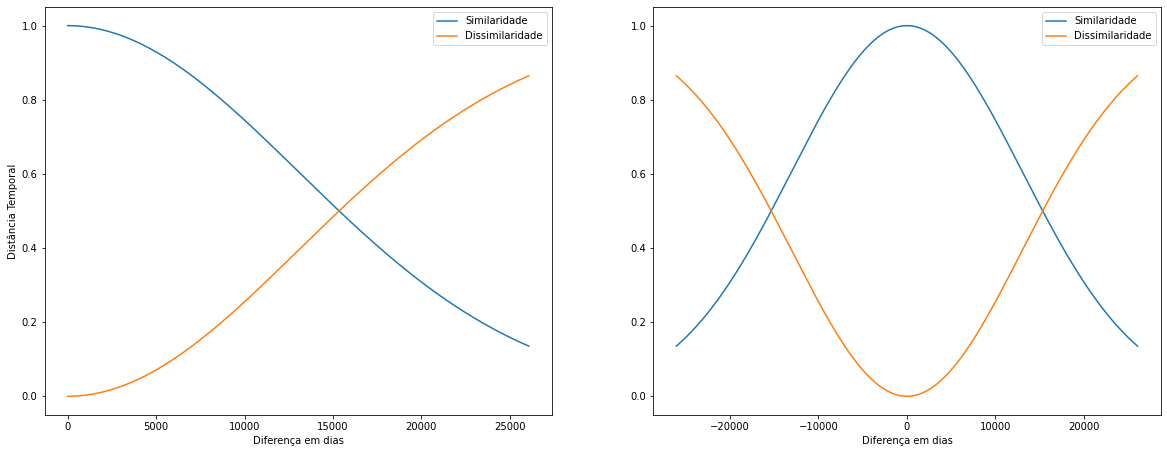

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize = (20, 7.5))
axes[0].plot(days_between, results, label = 'Similaridade')
axes[0].plot(days_between, 1 - results, label = 'Dissimilaridade')
axes[0].legend()

axes[0].set(ylabel = 'Distância Temporal', xlabel = 'Diferença em dias')

axes[1].plot(days_between2, results2, label = 'Similaridade')
axes[1].plot(days_between2, 1 - results2, label = 'Dissimilaridade')
axes[1].legend()

axes[1].set(xlabel = 'Diferença em dias')

plt.show()

##**Fitting do Reservatório**

In [ ]:
data = pd.read_pickle('/content/drive/Shareddrives/TCC 2022 - Marcelo/lp - paulo/data_v0_embeddings.pkl')

In [ ]:
data.loc[data['text'].str.contains("biden", case=False) & data['text'].str.contains("covid", case=False)]	

,_id,pub_date,chosen_type,text,what,when,where,who,why,how,coords,embedding
122757,nyt://article/6a9e38dd-76b2-5382-a721-5a274ad3...,2020-05-22 09:00:27,lead_paragraph,Joseph R. Biden Jr. speaks with Elizabeth Warr...,speaks with Elizabeth Warren a week,None,"Wilmington , Del.",Joseph R. Biden Jr.,They,the latest developments on the Covid-19 crisis...,"(39.7459468, -75.546589)","[0.02045701, -0.04869456, -0.0032564595, -0.00..."
126657,nyt://article/f3dd076a-1b78-538a-9712-26982fe5...,2020-07-17 09:00:16,lead_paragraph,"On July 9, former Vice President Joseph Biden ...",announced a new slogan,July 9,United States,former Vice President Joseph Biden,it,a new slogan for his campaign : “ Build Back,"(39.7837304, -100.445882)","[0.019999364, -0.06436053, -0.08292217, -0.047..."
132527,nyt://article/493ed577-08cc-5987-98dd-e7e7d327...,2020-10-07 00:30:40,lead_paragraph,"Joseph R. Biden Jr., the Democratic presidenti...",has Covid,next week,Miami,President Trump,he,"the Democratic presidential nominee , said on ...","(25.7741728, -80.19362)","[0.0076286006, 0.007422481, 0.016143778, -0.04..."
132569,nyt://article/c17b8b65-a8cc-5fae-b5e4-f0b6b891...,2020-10-07 14:00:30,abstract,Joseph R. Biden Jr. said on Tuesday night that...,has Covid,next week,Miami,President Trump,he,a presidential debate next week in Miami if Pr...,"(25.7741728, -80.19362)","[0.012405523, 0.015364655, 0.019056244, -0.049..."
134077,nyt://article/bc04eac9-0d44-5a5b-ab11-75ce03ce...,2020-10-27 17:42:47,abstract,"Former President Obama, delivering a withering...",is jealous of Covid ’s media coverage,Tuesday,Orlando,Trump,None,a withering speech in Orlando on behalf of Jos...,"(28.5421109, -81.3790304)","[-0.029695675, 0.02763269, -0.039348338, -0.02..."
137822,nyt://article/8b7257ea-471b-5dea-9ffa-bf9c428f...,2020-12-08 23:52:49,lead_paragraph,WASHINGTON — President-elect Joseph R. Biden J...,would make it,Tuesday,WASHINGTON,his,he,setting ambitious goals to change the course o...,"(38.8950368, -77.0365427)","[0.043652657, 0.03047734, -0.035960462, -0.029..."
140940,nyt://article/6a9d42f7-5ce8-5730-8c37-58c0e914...,2021-01-14 10:00:15,lead_paragraph,WASHINGTON — President-elect Joseph R. Biden J...,prepares to take office,Thursday,WASHINGTON,Mr. Biden,Joseph R. Biden Jr. on Thursday,the economic downturn and the Covid-19 crisis ...,"(38.8950368, -77.0365427)","[0.014624694, 0.00038167762, -0.024816789, 0.0..."
141319,nyt://video/46a4f91f-baff-5c7b-8fbd-ab73e343d74f,2021-01-19 21:43:26,abstract,President-elect Joseph R. Biden Jr. will parti...,None,None,Lincoln Memorial,None,President-elect Joseph R. Biden Jr.,None,"(38.88933725, -77.05017182493256)","[0.0043969103, 0.036158647, -0.07084897, -0.02..."
141555,nyt://article/46de38c9-dbea-53e1-8fba-820a3574...,2021-01-22 00:44:33,lead_paragraph,WASHINGTON — President Joseph R. Biden Jr. on ...,None,Thursday,White House,None,he,of new executive orders and presidential direc...,"(38.897699700000004, -77.03655315)","[-0.0043498576, 0.08068022, -0.02909917, -0.01..."
144091,nyt://article/3d2526ad-87a1-5a20-abd4-d0526b90...,2021-02-01 20:00:07,lead_paragraph,"In his victory speech, Joe Biden made a promis...",made a promise,None,America,Joe Biden,Joe Biden,’s Black community : “ You ’ve always had my,"(51.4371483, 5.9799001)","[0.0042504626, -0.015382825, -0.0051791635, -0..."


In [ ]:
data.iloc[151064]['text']	

'The Biden administration reversed course yesterday and came out in favor of suspending patent protections for Covid-19 vaccines. The move pits policymakers against drug companies, as infections in India, South America and elsewhere spiral, highlighting the urgency of more widespread vaccination.'

In [ ]:
reser = Reservoir(200, data.iloc[151064], event_generator, distance)

In [ ]:
reser.fit(alpha = 0.5, fitting_date = datetime.now())

157750it [07:22, 356.74it/s]


In [ ]:
reser_pickle_path = '/content/drive/Shareddrives/TCC 2022 - Marcelo/Atividade 2 - Construção da Rede de Eventos/reservatorio.pkl'
reser.to_pickle(reser_pickle_path)

##**Análise Resultados**

In [ ]:
reser_pickle_path = '/content/drive/Shareddrives/TCC 2022 - Marcelo/Atividade 2 - Construção da Rede de Eventos/reservatorio.pkl'
with open(reser_pickle_path, 'rb') as file:
    reser = pickle.load(file)

In [ ]:
frame = reser.to_frame()

frame

,_id,pub_date,chosen_type,text,what,when,where,who,why,how,coords,embedding,event distance,temporal distance,spatio distance,distance
0,nyt://article/b798df1e-660e-58d5-9931-e0e39543...,2021-07-30 22:24:56,lead_paragraph,"FLORHAM PARK, N.J. — As Zach Wilson flew on a ...",flew on a red-eye flight from California to th...,None,"FLORHAM PARK , N.J.",Zach Wilson,Zach Wilson,those premier seats that converts into a bed .,"(40.7881643, -74.3891647)","[0.011020833, 0.013177623, -0.014235441, -0.04...",0.549390,0.000022,0.304396,0.476815
1,nyt://article/72861dd9-2f13-541f-867f-284d94ab...,2016-07-29 00:27:37,lead_paragraph,"KUNDUZ CITY, Afghanistan — When President Ashr...",had finally been reclaimed after falling to th...,None,"KUNDUZ CITY , Afghanistan",the city,he,the northern provincial capital of Kunduz last...,"(36.7175566, 68.8672916)","[-0.0056552147, 0.08584182, 0.011292607, -0.00...",0.523455,0.008891,0.745899,0.380033
2,nyt://article/9b3dc90f-4279-5e41-80a5-82aebf74...,2016-07-22 01:29:43,lead_paragraph,Andy Warhol’s New York loft on East 47th Stree...,None,None,London,None,because every surface was embellished with alu...,the social life of postwar art what Gertrude S...,"(51.5073219, -0.1276474)","[0.018036358, 0.04019393, -0.022138659, -0.070...",0.502902,0.008963,0.482247,0.403741
3,nyt://article/6a7d4297-27de-565f-9c62-4cfa55c8...,2016-06-08 01:20:23,lead_paragraph,"Among the mighty of New York City, Howard P. M...",roams many corridors,None,New York City,Howard P. Milstein,Howard P. Milstein,"the mighty of New York City , Howard P. Milstein","(40.7127281, -74.0060152)","[0.033930343, 0.051225323, 0.049499623, -0.022...",0.523331,0.009417,0.303736,0.452482
4,nyt://article/9f3a233b-fc54-5af1-afa6-325e5a35...,2018-03-02 16:13:43,lead_paragraph,The young people who have come forward to call...,offer an inspiring example,None,"Parkland , Fla.",people,The young people who have come forward to call...,The young people who have come forward to call...,"(26.32540565, -80.27393647089306)","[-0.004352541, 0.029892875, -0.07771936, -0.02...",0.564515,0.003952,0.233138,0.504687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,nyt://article/3b3bba77-26a8-5c4e-8352-671c965b...,2017-01-03 18:18:21,lead_paragraph,"PREDAZZO, Italy — A half-mile above sea level ...",None,None,"PREDAZZO , Italy",None,Riccardo Felicetti,the fourth-generation pasta maker Riccardo Fel...,"(46.3123614, 11.6026938)","[-0.0043485877, -0.06420853, -0.06987711, -0.0...",0.512523,0.007348,0.511138,0.407008
196,nyt://article/44b60d1a-37a1-5043-a950-6ab44755...,2020-08-24 18:20:09,lead_paragraph,"Usain Bolt, the Olympic great who won eight go...",None,Monday,Instagram,None,"Usain Bolt , the Olympic great who won eight g...",Olympic great who won eight gold medals over t...,"(22.2890784, 114.1346515)","[0.040418882, 0.016277147, -0.028951803, -0.02...",0.607492,0.000190,0.951203,0.411665
197,nyt://article/aa246e85-d21d-556f-84ae-3247f2a9...,2017-07-19 13:08:58,lead_paragraph,London — Two court cases in London this week e...,travel to the United States for experimental t...,this week,London,Conway,him,"a seriously ill baby , Charlie Gard , are plea...","(51.5073219, -0.1276474)","[0.033268496, -0.060154594, 0.025909849, 0.009...",0.554330,0.005638,0.482247,0.445623
198,nyt://article/18f12052-849f-5228-b675-a6a9d05d...,2020-07-18 03:45:20,lead_paragraph,"Representative John Lewis, a son of sharecropp...",None,Friday,Jim Crow South,None,None,"the historic struggle for racial equality , an...","(-36.9897218, 149.147029)","[-0.073921405, -0.026097387, -0.02899667, -0.0...",0.576850,0.000251,0.662003,0.433355


In [ ]:
frame[['where', 'spatio distance']].sort_values(by = 'spatio distance', axis = 0)

,where,spatio distance
145,Venezuela,0.119828
103,Caribbean,0.183063
25,Daytona,0.183546
42,Florida Keys,0.226886
4,"Parkland , Fla.",0.233138
...,...,...
44,China,0.874032
94,China,0.874032
120,China,0.874032
122,BANGKOK — Thailand,0.931634


In [ ]:
frame[['pub_date', 'temporal distance']].sort_values(by = 'temporal distance', axis = 0)

,pub_date,temporal distance
10,2021-05-06 11:00:05,0.000000e+00
55,2021-05-07 10:00:08,2.943165e-09
76,2021-05-17 15:43:14,4.238156e-07
170,2021-05-24 10:00:09,9.535849e-07
193,2021-04-06 09:24:23,2.648845e-06
...,...,...
78,2015-07-15 15:01:22,1.315298e-02
144,2015-07-14 03:02:43,1.317763e-02
160,2015-07-07 20:34:10,1.325172e-02
16,2015-07-04 16:03:48,1.328884e-02


In [ ]:
frame[['text', 'event distance']].sort_values(by = 'event distance', axis = 0)

,text,event distance
149,This penthouse on the water in Oslo is on the ...,0.435949
110,"He’s played a gigolo, an officer, a lawyer and...",0.473881
28,This week’s properties include a six-bedroom i...,0.475837
6,"Composer portraits, anime scores and music in ...",0.481095
173,"TOKYO — Carlos Ghosn, the fallen head of the N...",0.484171
...,...,...
141,"BERLIN — In November, as Covid-19 cases began ...",0.645677
140,"WASHINGTON — President Trump, after failing t...",0.662093
64,WASHINGTON — The coronavirus pandemic remained...,0.694328
181,WASHINGTON — The scientist leading the Trump a...,0.722915


In [ ]:
for text in frame.sort_values(by = 'distance', axis = 0).iloc[-10:]['text']:
    print(text, end='\n\n')

Readers discuss whether to eliminate the filibuster, selling the Democratic agenda to the public, statehood for D.C. and more.

The Trump administration will begin allowing hunters to bring into the United States “trophy” elephants killed in Zimbabwe, reversing a 2014 ban on a practice that has received intense scrutiny in recent years.

WASHINGTON — American commandos captured a suspect in the 2012 attacks in Benghazi, Libya, the Trump administration said on Monday, bringing into custody a second man accused in the terrorist attacks that have been used by Republicans as a political spear against the Obama administration.

HOUSTON — President Trump played second fiddle on Sunday to Narendra Modi, the prime minister of India, at a boisterous cultural rally in which the American president was technically just an invited guest.

WASHINGTON — Eleven million people face a deep, abrupt cut in disability insurance benefits in late 2016 if Congress fails to replenish Social Security’s disabili